# Task1 - Faster RCNN


Using Pretrained model resnet 50 trained on COCO dataset and choosing two required labels -1 for person and 37 for soccer ball to perform region CNN


In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import cv2  # For video processing
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [2]:
# Load the pretrained Faster-RCNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()  # Set the model to evaluation mode


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
PERSON_LABEL = 1  # COCO dataset label for "person"
BALL_LABEL = 37   # COCO dataset label for "sports ball"

First , the video is split into frames and objects within each frame is identified  along with its boundary coordinates  . Furthur, each object is identified which class it belongs to and annotated . This annotated frame is then stored in debug_frames directory 

In [8]:
def detect_objects(frame, model, threshold=0.3,target_classes=[PERSON_LABEL, BALL_LABEL]):
    """
    Detect objects in a single frame using Faster-RCNN.
    """
    frame_tensor = F.to_tensor(frame).unsqueeze(0)
    with torch.no_grad():
        outputs = model(frame_tensor)[0]
    boxes = outputs['boxes'].cpu().numpy()
    scores = outputs['scores'].cpu().numpy()
    labels = outputs['labels'].cpu().numpy()

    # Filter detections by confidence threshold
    indices = (scores > threshold) & (labels[:, None] == target_classes).any(axis=1)
    boxes, scores, labels = boxes[indices], scores[indices], labels[indices]
    return boxes, scores, labels

In [9]:
def draw_boxes(frame, boxes, scores, labels, threshold=0.3):
    """
    Draw bounding boxes on the frame for detected objects.
    """
    frame_copy = frame.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        score = scores[i]
        label = labels[i]

        # Choose color: green for person, blue for ball, red for others
        if label == PERSON_LABEL:
            color = (0, 255, 0)  # Green
        elif label == BALL_LABEL:
            color = (255, 0, 0)  # Blue
        else:
            color = (0, 0, 255)  # Red

        # Draw bounding box and label
        cv2.rectangle(frame_copy, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            frame_copy,
            f"{label}:{score:.2f}",
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            2
        )
    return frame_copy


In [11]:
def process_video(input_path, output_path, model, threshold=0.3, debug_dir=None):
    """
    Process the input video and save the output with drawn detections.
    Optionally save debug frames to a directory.
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Unable to open video file: {input_path}")

    # Video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    all_bounding_boxes = []  
    # Optional debug frame saving
    if debug_dir:
        import os
        os.makedirs(debug_dir, exist_ok=True)

    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Detect objects
        boxes, scores, labels = detect_objects(frame, model, threshold)
        # print(f"{boxes}")
        all_bounding_boxes.append(boxes)
      
        # Draw filtered detections
        processed_frame = draw_boxes(frame, boxes, scores, labels, threshold)

        # Save debug frame if enabled
        if debug_dir:
            cv2.imwrite(f"{debug_dir}/processed_frame_{frame_index:04d}.jpg", processed_frame)
        all_bounding_boxes.append(boxes)
        # print(f"all bounding box:{all_bounding_boxes}")
        
        # Write to output video
        out.write(processed_frame)
        frame_index += 1
        print(f"Processed frame {frame_index}")
    # np.save('bounding_boxes_task2.npy', all_bounding_boxes)
    # print(f"Bounding boxes saved to 'bounding_boxes_task2.npy' for Task 2")
    # Release resources
    cap.release()
    out.release()
    print(f"Video processing completed. Saved to {output_path}")
    return all_bounding_boxes


In [12]:
if __name__ == "__main__":
    # Input and output paths
    input_video_path = "Footballmatch.mp4"  # Replace with your input video file
    output_video_path = "task1_game.mp4"
    debug_frames_dir = "debug_frames"  # Optional directory for debug frames

    # Process video
    all_bounding_boxes=process_video(input_video_path, output_video_path, model, threshold=0.3, debug_dir=debug_frames_dir)

Processed frame 1
Processed frame 2
Processed frame 3
Processed frame 4
Processed frame 5
Processed frame 6
Processed frame 7
Processed frame 8
Processed frame 9
Processed frame 10
Processed frame 11
Processed frame 12
Processed frame 13
Processed frame 14
Processed frame 15
Processed frame 16
Processed frame 17
Processed frame 18
Processed frame 19
Processed frame 20
Processed frame 21
Processed frame 22
Processed frame 23
Processed frame 24
Processed frame 25
Processed frame 26
Processed frame 27
Processed frame 28
Processed frame 29
Processed frame 30
Processed frame 31
Processed frame 32
Processed frame 33
Processed frame 34
Processed frame 35
Processed frame 36
Processed frame 37
Processed frame 38
Processed frame 39
Processed frame 40
Processed frame 41
Processed frame 42
Processed frame 43
Processed frame 44
Processed frame 45
Processed frame 46
Processed frame 47
Processed frame 48
Processed frame 49
Processed frame 50
Processed frame 51
Processed frame 52
Processed frame 53
Pr

The below is an example frame with annotations stored in debug_frames directory
the key steps include :
1) Input Processing : frame is loaded and BGR to RGB conversion for matplotlib display
2) Object detection : Faster-RCNN detects objects and returns bounding boxes, confidence scores, and labels for each detected object.

##### Object detection using Faster-RCNN involves several key steps:

* __Feature Extraction__: A convolutional neural network (CNN) is used to extract feature maps from the input image.
* __Region Proposal Network (RPN)__: The RPN generates a set of potential object regions (proposals) from the feature map by sliding over it, predicting bounding boxes and objectness scores for each region.
* __RoI Pooling__: The proposed regions are then resized to a fixed size using Region of Interest (RoI) pooling, enabling uniform feature representation.
* __Classification and Bounding Box Regression__: The pooled regions are passed through fully connected layers to classify the objects within each region and refine the bounding box coordinates.
* __Output__: The final predictions include bounding boxes, class labels, and confidence scores for each detected object in the frame.
In this specific case, Faster-RCNN detects players (class label 'person') and the ball (class label 'ball') by processing the frame through these steps, and bounding boxes are drawn around each detected object based on the predicted coordinates.

3) Bounding Boxes - are drawn to detect objects 
    * Green for persons (soccer players).
    * Blue for the soccer ball.
    * Red for any other objects, although in this task, we primarily focus on the person and ball.
4) Confidence Scores:
Each bounding box is labeled with a confidence score, which reflects how confident the model is in its detection. The higher the score, the more likely it is that the detection is correct.


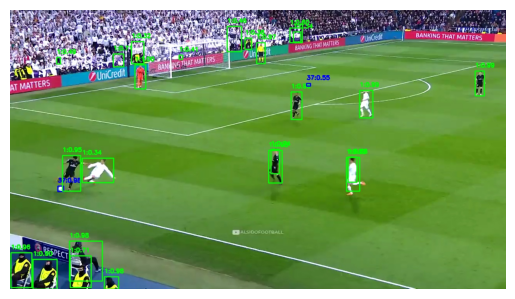

In [17]:

image_path = 'debug_frames/processed_frame_0156.jpg'  # Your image path

image = cv2.imread(image_path)

# Convert the image from BGR (OpenCV default) to RGB for correct color display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

# Task 2 - Deep sort
###### without using inbuilt library

## Kalman Filter

The **Kalman filter** is an optimal recursive data processing algorithm that estimates the state of a dynamic system from a series of noisy measurements. It is widely used in fields such as control systems, robotics, and navigation.

### Key Concepts:
- **State Vector ($x$)**: Represents the internal state of the system at any given time. This could be the position and velocity of an object, for example.
- **Prediction Step**: Uses the current state estimate and a model of the system's dynamics to predict the next state.
- **Update Step**: Refines the predicted state using measurements or observations of the system.

### Kalman Filter Equations:

#### Prediction:
1. **State Prediction:**
   $$ \hat{x}_{k|k-1} = A \hat{x}_{k-1|k-1} + B u_{k} $$
   where:
   - $A$ is the state transition matrix.
   - $\hat{x}_{k-1|k-1}$ is the previous state estimate.
   - $B$ is the control input matrix.
   - $u_k$ is the control vector.

2. **Covariance Prediction:**
   $$ P_{k|k-1} = A P_{k-1|k-1} A^T + Q $$
   where:
   - $P_{k|k-1}$ is the predicted error covariance.
   - $Q$ is the process noise covariance.

#### Update:
1. **Kalman Gain:**
   $$ K_k = P_{k|k-1} H^T (H P_{k|k-1} H^T + R)^{-1} $$
   where:
   - $H$ is the measurement matrix.
   - $R$ is the measurement noise covariance.

2. **State Update:**
   $$ \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H \hat{x}_{k|k-1}) $$
   where:
   - $z_k$ is the actual measurement at time $k$.
   - $\hat{x}_{k|k}$ is the updated state estimate.

3. **Covariance Update:**
   $$ P_{k|k} = (I - K_k H) P_{k|k-1} $$

---

## Hungarian Algorithm

The **Hungarian algorithm** is an efficient method to solve the **assignment problem**, which involves finding the optimal way to assign tasks to workers in order to minimize total cost or maximize total profit.

Given a cost matrix $C$ where each element $C_{ij}$ represents the cost of assigning task $j$ to worker $i$, the goal is to find the minimum total cost of assignments.

### Steps of the Hungarian Algorithm:

1. **Subtract Row Minimums:**
   Subtract the smallest value in each row of the matrix from all the elements in that row.

   $$ C'_{ij} = C_{ij} - \min(C_{i1}, C_{i2}, \dots, C_{in}) $$

2. **Subtract Column Minimums:**
   After row reduction, subtract the smallest value in each column from all the elements in that column.

   $$ C''_{ij} = C'_{ij} - \min(C'_{1j}, C'_{2j}, \dots, C'_{mj}) $$

3. **Cover Zeros with Lines:**
   Cover all zeros in the matrix with a minimum number of horizontal and vertical lines. This step is crucial for determining which assignments to make.

4. **Test for Optimality:**
   If the number of lines covering zeros equals the number of rows (or columns), then the current solution is optimal, and the algorithm ends. If not, proceed to the next step.

5. **Create Additional Zeros:**
   Uncover all lines. Find the smallest uncovered value in the matrix, subtract it from all uncovered elements, and add it to all elements that are covered twice.

6. **Repeat Steps 3 to 5:**
   Keep repeating the process of covering zeros and creating additional zeros until the optimal assignment is found.

### Mathematical Formulation:
Given the **cost matrix** $C$, the goal is to find a permutation $\pi$ such that the total cost is minimized:

$$ \text{Total cost} = \sum_{i=1}^n C_{i, \pi(i)} $$

Where $\pi(i)$ is the assignment of task $i$ to worker $\pi(i)$, and $n$ is the number of tasks (or workers).


## Intersection over Union (IoU)

**Intersection over Union (IoU)** is a metric used to evaluate the performance of object detection models. It is commonly used to measure the overlap between two bounding boxes — one predicted by the model and one ground truth.

IoU is defined as the ratio of the area of overlap between the predicted bounding box and the ground truth bounding box to the area of their union.

### IoU Formula:
Given two bounding boxes, the **predicted box** and the **ground truth box**, the IoU can be calculated as:

$$ \text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}} $$

Where:

- **Area of Overlap** is the area where the predicted bounding box and the ground truth bounding box intersect.
- **Area of Union** is the total area covered by both boxes combined.

### Steps to Calculate IoU:

1. **Calculate the Coordinates of the Intersection Box:**
   - Find the coordinates of the overlap region between the two bounding boxes.
   - Let the coordinates of the predicted bounding box be $(x_1, y_1, x_2, y_2)$, where $(x_1, y_1)$ is the top-left corner and $(x_2, y_2)$ is the bottom-right corner.
   - Similarly, let the coordinates of the ground truth bounding box be $(x_3, y_3, x_4, y_4)$.
   - The intersection box’s coordinates are:
     - $x_{\text{int}} = \max(x_1, x_3)$
     - $y_{\text{int}} = \max(y_1, y_3)$
     - $x_{\text{int\_2}} = \min(x_2, x_4)$
     - $y_{\text{int\_2}} = \min(y_2, y_4)$

2. **Calculate the Area of the Intersection Box:**
   The area of the intersection is given by:

   $$ \text{Area of Intersection} = \max(0, x_{\text{int\_2}} - x_{\text{int}}) \times \max(0, y_{\text{int\_2}} - y_{\text{int}}) $$

3. **Calculate the Area of the Union:**
   The area of the union of the two boxes is:

   $$ \text{Area of Union} = \text{Area of Predicted Box} + \text{Area of Ground Truth Box} - \text{Area of Intersection} $$

   where:
   - $\text{Area of Predicted Box} = (x_2 - x_1) \times (y_2 - y_1)$
   - $\text{Area of Ground Truth Box} = (x_4 - x_3) \times (y_4 - y_3)$

4. **Calculate IoU:**
   Finally, the IoU is calculated as:

   $$ \text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}} $$

### IoU Thresholds:

- A high IoU value (typically > 0.5) indicates that the predicted bounding box is a good match for the ground truth.
- An IoU value below a threshold (such as 0.5) may indicate a poor prediction, meaning the model's bounding box is far from the true object.

### Use of IoU:

IoU is crucial for evaluating object detection algorithms like YOLO (You Only Look Once) and SSD (Single Shot Multibox Detector). It helps determine how well the model is localizing objects in the image. During training, IoU is often used to calculate the loss function, and during evaluation, it is used for metrics like precision, recall, and mean average precision (mAP).


### Architecture 

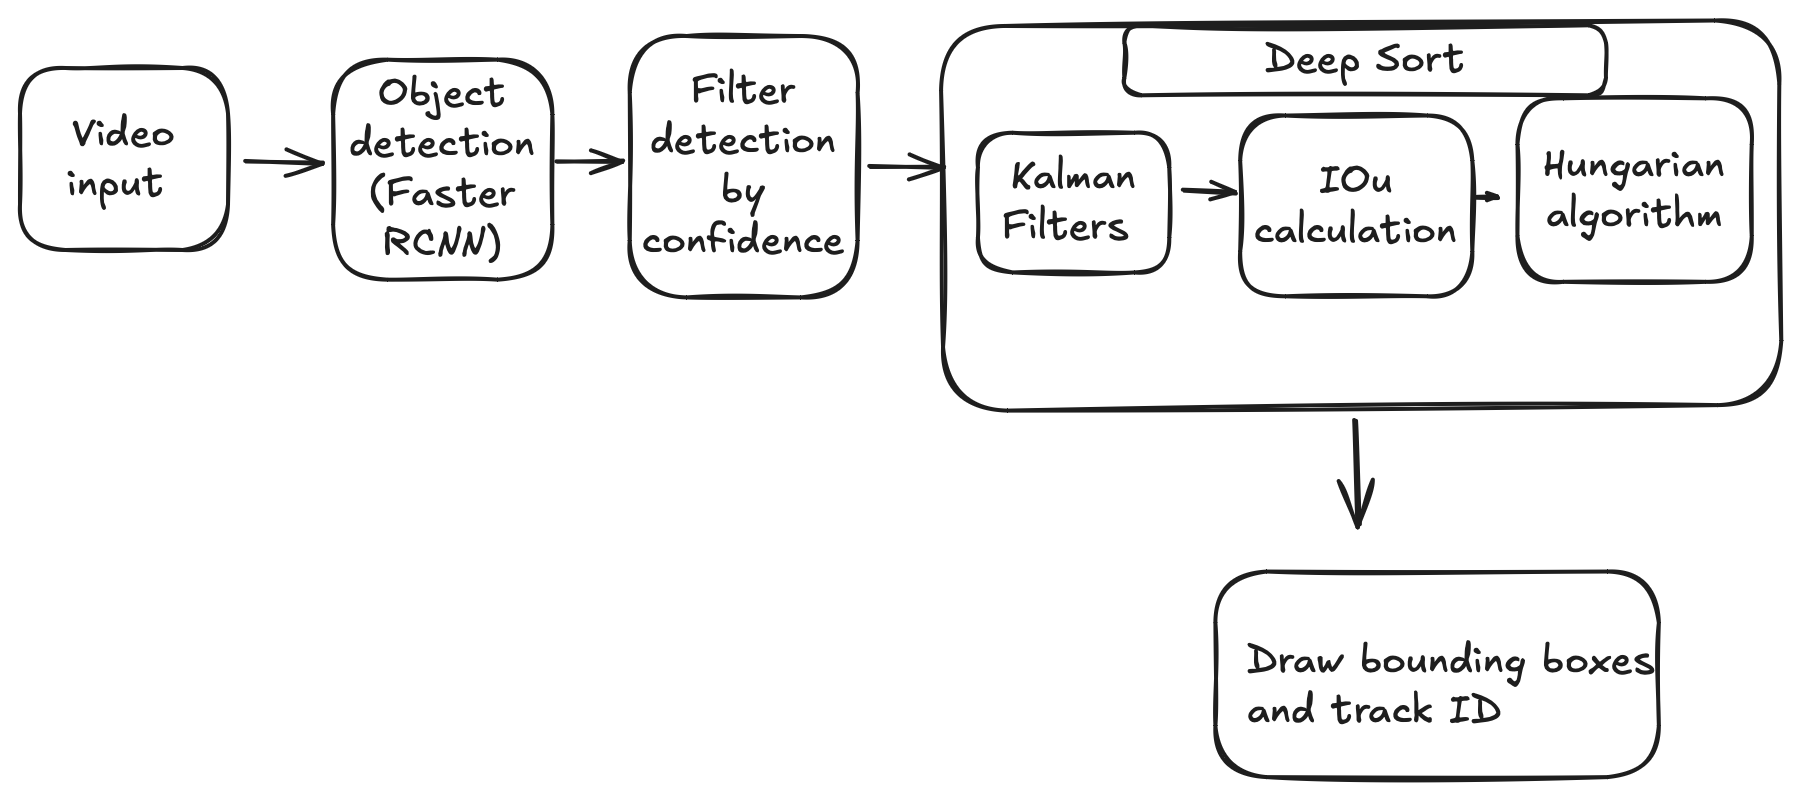

In [1]:
from IPython.display import Image, SVG

Image("arch.png")

1) ##### Kalman Filter:
Purpose: Predicts the future position of objects based on their motion, ensuring smooth tracking even during occlusions.
How it works: It uses the object's position and velocity to predict its next location, then updates the prediction using the actual detection when available. This helps handle temporary misses or noise in detections.

2. ##### IoU (Intersection over Union):
Purpose: Measures the overlap between the predicted and detected bounding boxes to assess how well they match.
How it works: It calculates the ratio of the intersection area to the union area of the predicted and detection bounding boxes. Higher IoU indicates a better match

3. ##### Hungarian Algorithm:
Purpose: Solves the assignment problem by matching predicted objects to detections based on IoU scores.
How it works: It creates a cost matrix with IoU values, then uses the Hungarian Algorithm to find the optimal assignment that minimizes the total cost (maximizing IoU).

In [1]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from collections import defaultdict


In [8]:
# Initialize Faster-RCNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

/Users/debikad/Desktop/AI/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/debikad/Desktop/AI/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [2]:
# Define video paths
input_video_path = "Footballmatch.mp4"  # Replace with your video path
output_video_path = "output_of_task_2.mp4"

In [3]:
# Load the video
cap = cv2.VideoCapture(input_video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [4]:
# Define preprocessing transformations for the detector
transform = transforms.Compose([transforms.ToTensor()])

# Thresholds
confidence_threshold = 0.7
iou_threshold = 0.5


In [5]:
# ID tracking data structures
next_person_id = 1
next_ball_id = 1
active_ids = defaultdict(dict)  # Format: {'person': {id: bbox}, 'ball': {id: bbox}}

In [6]:
# Helper function to compute IoU
def compute_iou(box1, box2):
    x1, y1 = np.maximum(box1[:2], box2[:2])
    x2, y2 = np.minimum(box1[2:], box2[2:])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

In [ ]:
class KalmanFilter:
    def __init__(self, dt=1):
        self.dt = dt  # Time step
        self.state = None  # State vector: [x, y, w, h, v_x, v_y, v_w, v_h]
        self.covariance = None  # Uncertainty matrix
        self.process_noise = np.eye(8) * 0.1  # Small noise for the process model
        self.measurement_noise = np.eye(4) * 1  # Larger noise for measurement

    def init(self, measurement):
        """Initialize the Kalman filter with a measurement."""
        self.state = np.array([measurement[0], measurement[1], measurement[2], measurement[3], 0, 0, 0, 0])
        self.covariance = np.eye(8) * 1000  # High initial uncertainty

    def predict(self):
        """Predict the next state and uncertainty."""
        # State transition matrix
        F = np.array([[1, 0, 0, 0, self.dt, 0, 0, 0],
                      [0, 1, 0, 0, 0, self.dt, 0, 0],
                      [0, 0, 1, 0, 0, 0, self.dt, 0],
                      [0, 0, 0, 1, 0, 0, 0, self.dt],
                      [0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1]])
        self.state = F @ self.state
        self.covariance = F @ self.covariance @ F.T + self.process_noise

    def update(self, measurement):
        """Update the state based on the measurement."""
        # Observation matrix (maps state to measurement)
        H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0, 0]])
        
        # Measurement residual
        y = measurement - H @ self.state
        
        # Residual covariance
        S = H @ self.covariance @ H.T + self.measurement_noise
        
        # Kalman gain
        K = self.covariance @ H.T @ np.linalg.inv(S)
        
        # Update the state
        self.state = self.state + K @ y
        
        # Update the uncertainty
        self.covariance = (np.eye(8) - K @ H) @ self.covariance


In [9]:
# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to tensor
    img_tensor = transform(frame).unsqueeze(0)

    # Perform object detection
    with torch.no_grad():
        detections = model(img_tensor)[0]

    # Extract boxes, scores, and labels
    boxes = detections['boxes'].cpu().numpy()
    scores = detections['scores'].cpu().numpy()
    labels = detections['labels'].cpu().numpy()

    # Filter for high-confidence detections
    indices = np.where(scores > confidence_threshold)[0]
    boxes = boxes[indices]
    labels = labels[indices]

    # Temporary storage for current frame IDs
    current_frame_ids = {'person': {}, 'ball': {}}

    for box, label in zip(boxes, labels):
        # Ensure box has four values
        if len(box) != 4:
            continue

        # Define classes: 1 -> Person, 37 -> Sports Ball
        if label == 1:  # Person
            object_type = 'person'
        elif label == 37:  # Sports Ball
            object_type = 'ball'
        else:
            continue

        # Match with existing IDs using IoU
        matched_id = None
        for obj_id, prev_box in active_ids[object_type].items():
            if compute_iou(box, prev_box) > iou_threshold:
                matched_id = obj_id
                break

        if matched_id is None:  # New ID
            if object_type == 'person':
                matched_id = next_person_id
                next_person_id += 1
            else:  # Ball
                matched_id = next_ball_id
                next_ball_id += 1

        # Update active IDs and current frame IDs
        active_ids[object_type][matched_id] = box
        current_frame_ids[object_type][matched_id] = box

        # Draw the bounding box and label
        x1, y1, x2, y2 = map(int, box)
        color = (0, 255, 0) if object_type == 'person' else (0, 0, 255)
        label_text = f"{object_type.capitalize()} ID {matched_id}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Write frame to the output video
    out.write(frame)

    # Update active IDs (remove stale IDs)
    for object_type in active_ids:
        active_ids[object_type] = {
            obj_id: box
            for obj_id, box in active_ids[object_type].items()
            if obj_id in current_frame_ids[object_type]
        }



In [10]:

# Release resources
cap.release()
out.release()
print(f"Processing complete. Output saved to {output_video_path}")

Processing complete. Output saved to fina_debika_output_with_ids.mp4
